# True Volatility

In [22]:
import pandas as pd
import numpy as np

# Function to calculate annualized volatility
def calculate_annualized_volatility(returns):
    return returns.std() * np.sqrt(252)

# List of ETFs
etfs = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'SPY']
results = []

for etf in etfs:
    # Read the CSV data
    df = pd.read_csv(f"{etf}.csv")
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the dataframe by date
    df = df.sort_values('Date')
    
    # Convert 'Adj Close' to numeric, coercing errors to NaN
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    
    # Calculate daily returns
    df['Return'] = df['Adj Close'].pct_change(fill_method=None)
    
    # Group by year
    grouped = df.groupby(df['Date'].dt.year)
    
    # Calculate annualized volatility for each year
    for year, group in grouped:
        volatility = calculate_annualized_volatility(group['Return'].dropna())
        results.append({
            'ETF': etf,
            'Year': int(year),  # Convert year to integer
            'Annualized_Volatility': volatility
        })

# Create a dataframe from the results
volatility_df = pd.DataFrame(results)

# Display results
print(volatility_df)

# Save results to a CSV file
volatility_df.to_csv('etf_annualized_volatility.csv', index=False)


     ETF  Year  Annualized_Volatility
0    XLB  2000               0.311365
1    XLB  2001               0.270038
2    XLB  2002               0.289574
3    XLB  2003               0.187578
4    XLB  2004               0.170822
..   ...   ...                    ...
245  SPY  2020               0.333980
246  SPY  2021               0.129887
247  SPY  2022               0.242430
248  SPY  2023               0.130756
249  SPY  2024               0.125858

[250 rows x 3 columns]


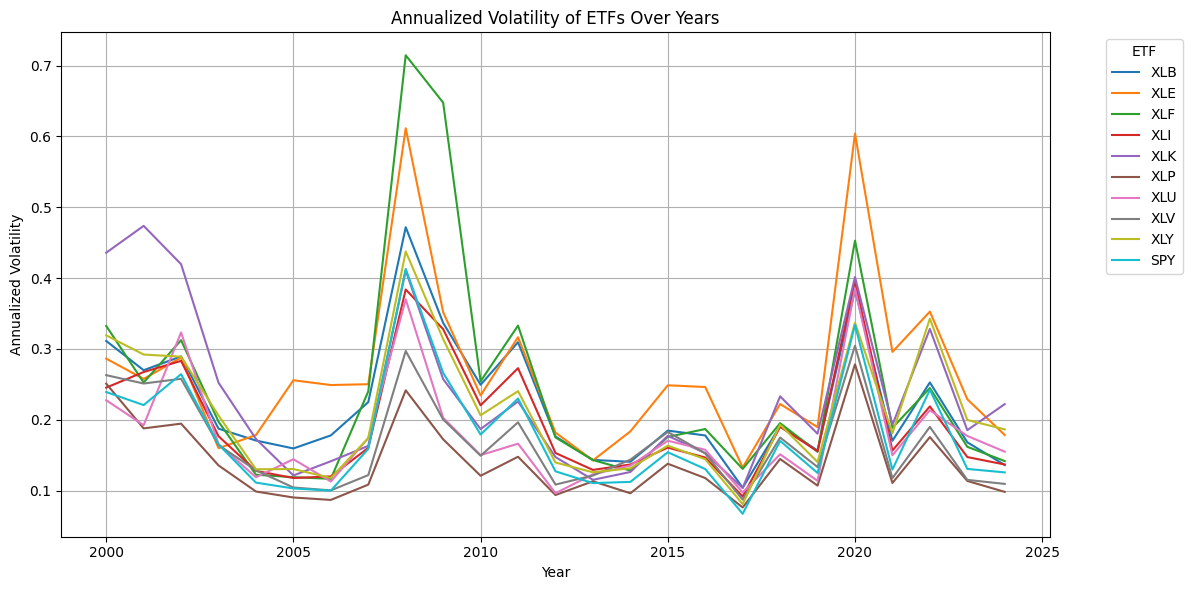

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
volatility_df = pd.read_csv('etf_annualized_volatility.csv')

# Plot the data
plt.figure(figsize=(12, 6))
for etf in volatility_df['ETF'].unique():
    etf_data = volatility_df[volatility_df['ETF'] == etf]
    plt.plot(etf_data['Year'], etf_data['Annualized_Volatility'], label=etf)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Annualized Volatility')
plt.title('Annualized Volatility of ETFs Over Years')
plt.legend(title='ETF', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Function to calculate switches and classify them as LSTM, CNN, or RNN
def calculate_switches_and_classify(data):
    switches = 0
    lstm_switches = 0
    cnn_switches = 0
    rnn_switches = 0
    prev_sign = None

    for _, row in data.iterrows():
        current_sign = np.sign(row['Daily_Return'])
        if prev_sign is not None and current_sign != prev_sign:
            switches += 1
            # Classification logic (customize as needed):
            if abs(row['Daily_Return']) > 0.02:  # Large change classified as LSTM
                lstm_switches += 1
            elif abs(row['Daily_Return']) > 0.01:  # Moderate change classified as CNN
                cnn_switches += 1
            else:  # Small change classified as RNN
                rnn_switches += 1
        prev_sign = current_sign

    return switches, lstm_switches, cnn_switches, rnn_switches

# Function to calculate average positive and negative streak lengths
def calculate_avg_lengths(data):
    positive_lengths = []
    negative_lengths = []
    
    streak = 1
    data_values = data.values  # Convert Series to NumPy array
    prev_sign = np.sign(data_values[0])  # First value's sign
    
    for i in range(1, len(data_values)):
        current_sign = np.sign(data_values[i])
        if current_sign == prev_sign:
            streak += 1
        else:
            if prev_sign > 0:
                positive_lengths.append(streak)
            elif prev_sign < 0:
                negative_lengths.append(streak)
            streak = 1
        prev_sign = current_sign
    
    # Add the last streak
    if prev_sign > 0:
        positive_lengths.append(streak)
    elif prev_sign < 0:
        negative_lengths.append(streak)
    
    avg_positive = np.mean(positive_lengths) if positive_lengths else 0
    avg_negative = np.mean(negative_lengths) if negative_lengths else 0
    return avg_positive, avg_negative

# List of ETFs
etfs = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'SPY']

# Dictionary to store results
results = {}

for etf in etfs:
    try:
        # Read CSV file
        df = pd.read_csv(f'{etf}.csv')
        
        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Sort by date
        df = df.sort_values('Date')

        # Convert 'Adj Close' to numeric, coercing errors to NaN
        df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')

        # Calculate daily returns
        df['Daily_Return'] = df['Adj Close'].pct_change()

        # Remove rows with NaN values
        df = df.dropna()
        
        # Calculate switches and classify them
        total_switches, lstm_switches, cnn_switches, rnn_switches = calculate_switches_and_classify(df)
        
        # Calculate switches for the last year
        last_year = df[df['Date'] >= df['Date'].max() - timedelta(days=365)]
        yearly_switches, _, _, _ = calculate_switches_and_classify(last_year)
        
        # Calculate average positive and negative streak lengths
        avg_positive, avg_negative = calculate_avg_lengths(df['Daily_Return'])
        
        # Store results
        results[etf] = {
            'Total_Switches': total_switches,
            'Yearly_Switches': yearly_switches,
            'LSTM_Switches': lstm_switches,
            'CNN_Switches': cnn_switches,
            'RNN_Switches': rnn_switches,
            'Avg_Positive_Length': avg_positive,
            'Avg_Negative_Length': avg_negative
        }
    except FileNotFoundError:
        print(f"File for {etf} not found. Skipping...")

# Find the most volatile ETF based on total switches
most_volatile_etf = max(results, key=lambda x: results[x]['Total_Switches'])

# Print the most volatile ETF's details
print(f"Most Volatile ETF: {most_volatile_etf}")
print(f"Total Number of Switches: {results[most_volatile_etf]['Total_Switches']}")
print(f"Number of Switches in Last Year: {results[most_volatile_etf]['Yearly_Switches']}")
print(f"LSTM Switches: {results[most_volatile_etf]['LSTM_Switches']}")
print(f"CNN Switches: {results[most_volatile_etf]['CNN_Switches']}")
print(f"RNN Switches: {results[most_volatile_etf]['RNN_Switches']}")
print(f"Average Positive Length: {results[most_volatile_etf]['Avg_Positive_Length']:.2f}")
print(f"Average Negative Length: {results[most_volatile_etf]['Avg_Negative_Length']:.2f}")

# Print results for all ETFs
print("\nResults for all ETFs:")
for etf, data in results.items():
    print(f"{etf}:")
    print(f"  Total Switches: {data['Total_Switches']}")
    print(f"  Yearly Switches: {data['Yearly_Switches']}")
    print(f"  LSTM Switches: {data['LSTM_Switches']}")
    print(f"  CNN Switches: {data['CNN_Switches']}")
    print(f"  RNN Switches: {data['RNN_Switches']}")
    print(f"  Avg Positive Length: {data['Avg_Positive_Length']:.2f}")
    print(f"  Avg Negative Length: {data['Avg_Negative_Length']:.2f}")


C:\Users\tripa\AppData\Local\Temp\ipykernel_87324\603958899.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df['Adj Close'].pct_change()
C:\Users\tripa\AppData\Local\Temp\ipykernel_87324\603958899.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df['Adj Close'].pct_change()
C:\Users\tripa\AppData\Local\Temp\ipykernel_87324\603958899.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_me

Most Volatile ETF: XLP
Total Number of Switches: 3419
Number of Switches in Last Year: 119
LSTM Switches: 149
CNN Switches: 550
RNN Switches: 2720
Average Positive Length: 2.00
Average Negative Length: 1.74

Results for all ETFs:
XLB:
  Total Switches: 3266
  Yearly Switches: 123
  LSTM Switches: 415
  CNN Switches: 845
  RNN Switches: 2006
  Avg Positive Length: 2.05
  Avg Negative Length: 1.83
XLE:
  Total Switches: 3185
  Yearly Switches: 115
  LSTM Switches: 591
  CNN Switches: 904
  RNN Switches: 1690
  Avg Positive Length: 2.07
  Avg Negative Length: 1.90
XLF:
  Total Switches: 3365
  Yearly Switches: 110
  LSTM Switches: 481
  CNN Switches: 759
  RNN Switches: 2125
  Avg Positive Length: 1.97
  Avg Negative Length: 1.81
XLI:
  Total Switches: 3262
  Yearly Switches: 134
  LSTM Switches: 316
  CNN Switches: 750
  RNN Switches: 2196
  Avg Positive Length: 2.09
  Avg Negative Length: 1.80
XLK:
  Total Switches: 3237
  Yearly Switches: 131
  LSTM Switches: 501
  CNN Switches: 760
  

In [11]:
# Calculate combined switches for all ETFs
total_lstm_switches = sum(data['LSTM_Switches'] for data in results.values())
total_cnn_switches = sum(data['CNN_Switches'] for data in results.values())
total_rnn_switches = sum(data['RNN_Switches'] for data in results.values())

# Print combined results
print("\nCombined Results for All ETFs:")
print(f"Total LSTM Switches: {total_lstm_switches}")
print(f"Total CNN Switches: {total_cnn_switches}")
print(f"Total RNN Switches: {total_rnn_switches}")



Combined Results for All ETFs:
Total LSTM Switches: 3546
Total CNN Switches: 7299
Total RNN Switches: 21792


# Predicted Close to Close Volatility

In [5]:
import pandas as pd
import numpy as np

# Function to calculate annualized volatility
def calculate_annualized_volatility(returns):
    return returns.std() * np.sqrt(250)

# Load the dataset
file_path = 'etf_predicted_returns.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

# Sort the dataframe by date
data = data.sort_values('date')

# Group by ETF, model, and year
results = []
data['year'] = data['date'].dt.year
grouped = data.groupby(['etf', 'model', 'year'])

# Calculate annualized volatility for each ETF, model, and year
for (etf, model, year), group in grouped:
    volatility = calculate_annualized_volatility(group['predicted_daily_returns'])
    results.append({
        'ETF': etf,
        'Model': model,
        'Year': year,
        'Annualized_Volatility': volatility
    })

# Create a dataframe from the results
volatility_df = pd.DataFrame(results)

# Display results
print(volatility_df)

# Save results to a CSV file
volatility_df.to_csv('ctc_annualized_volatility.csv', index=False)

# Calculate average annualized volatility for each model
model_volatility = volatility_df.groupby('Model')['Annualized_Volatility'].mean().sort_values(ascending=False)

print("\nAverage Annualized Volatility by Model:")
print(model_volatility)


     ETF Model  Year  Annualized_Volatility
0    SPY   cnn  2000               0.009233
1    SPY   cnn  2001               0.219922
2    SPY   cnn  2002               0.265131
3    SPY   cnn  2003               0.161648
4    SPY   cnn  2004               0.111935
..   ...   ...   ...                    ...
745  XLY   rnn  2020               0.335994
746  XLY   rnn  2021               0.182389
747  XLY   rnn  2022               0.342409
748  XLY   rnn  2023               0.199177
749  XLY   rnn  2024               0.185783

[750 rows x 4 columns]

Average Annualized Volatility by Model:
Model
rnn     0.199346
cnn     0.199344
lstm    0.199281
Name: Annualized_Volatility, dtype: float64


In [6]:
import pandas as pd
import numpy as np

# Function to calculate annualized volatility
def calculate_annualized_volatility(returns):
    return returns.std() * np.sqrt(250)

# Load the dataset
file_path = 'etf_predicted_returns.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

# Sort the dataframe by date
data = data.sort_values('date')

# Group by ETF and model
grouped = data.groupby(['etf', 'model'])

# Calculate overall statistics for each ETF and model
overall_results = []
for (etf, model), group in grouped:
    # Calculate annualized volatility for each year
    volatility_years = []
    for year in group['date'].dt.year.unique():
        year_group = group[group['date'].dt.year == year]
        volatility = calculate_annualized_volatility(year_group['predicted_daily_returns'])
        volatility_years.append(volatility)
    
    # Calculate overall statistics
    avg_volatility = np.mean(volatility_years)
    median_volatility = np.median(volatility_years)
    std_dev_volatility = np.std(volatility_years)
    
    # Calculate the amount generated using actual returns
    amount = 100
    for _, row in group.iterrows():
        amount *= (1 + row['predicted_daily_returns'])
    
    overall_results.append({
        'ETF': etf,
        'Model': model,
        'Amount': amount,
        'Average Volatility': avg_volatility,
        'Median Volatility': median_volatility,
        'Standard Deviation Volatility': std_dev_volatility
    })

# Create a dataframe from the overall results
overall_df = pd.DataFrame(overall_results)

# Save overall results to a CSV file
overall_df.to_csv('overall_etf_volatility.csv', index=False)

# Display overall results
print(overall_df)


    ETF Model       Amount  Average Volatility  Median Volatility  \
0   SPY   cnn   353.934942            0.167067           0.131425   
1   SPY  lstm   439.893478            0.167023           0.131425   
2   SPY   rnn   195.897238            0.167050           0.131425   
3   XLB   cnn   512.813609            0.208978           0.177024   
4   XLB  lstm   378.759319            0.208989           0.177024   
5   XLB   rnn   106.213165            0.209240           0.177024   
6   XLE   cnn   217.754808            0.263805           0.246388   
7   XLE  lstm   249.709288            0.263675           0.246388   
8   XLE   rnn    12.578575            0.264246           0.247548   
9   XLF   cnn    80.347782            0.238734           0.186719   
10  XLF  lstm    50.631259            0.239146           0.186719   
11  XLF   rnn    23.747515            0.238944           0.186719   
12  XLI   cnn   419.417765            0.203507           0.159974   
13  XLI  lstm   434.879940        

In [7]:
import pandas as pd
import numpy as np

# Function to calculate annualized volatility
def calculate_annualized_volatility(returns):
    return returns.std() * np.sqrt(250)

# Load the dataset
file_path = 'etf_predicted_returns.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

# Sort the dataframe by date
data = data.sort_values('date')

# Group by ETF and model
grouped = data.groupby(['etf', 'model'])

# Calculate overall statistics for each ETF and model
overall_results = []
for (etf, model), group in grouped:
    # Calculate annualized volatility for each year
    volatility_years = []
    for year in group['date'].dt.year.unique():
        year_group = group[group['date'].dt.year == year]
        volatility = calculate_annualized_volatility(year_group['predicted_daily_returns'])
        volatility_years.append(volatility)

    # Calculate overall statistics
    avg_volatility = np.mean(volatility_years)
    median_volatility = np.median(volatility_years)
    std_dev_volatility = np.std(volatility_years)

    # Calculate the amount generated using actual returns
    amount = 100
    for _, row in group.iterrows():
        amount *= (1 + row['predicted_daily_returns'])

    overall_results.append({
        'ETF': etf,
        'Model': model,
        'Amount': amount,
        'Average Volatility': avg_volatility,
        'Median Volatility': median_volatility,
        'Standard Deviation Volatility': std_dev_volatility
    })

# Add Buy and Hold model
buy_and_hold_results = []
for etf in data['etf'].unique():
    etf_group = data[data['etf'] == etf]
    
    # Calculate annualized volatility for the entire period
    avg_volatility = calculate_annualized_volatility(etf_group['predicted_daily_returns'])
    median_volatility = np.median(etf_group['predicted_daily_returns'])
    std_dev_volatility = np.std(etf_group['predicted_daily_returns'])

    # Calculate the amount generated using actual returns
    amount = 100
    for _, row in etf_group.iterrows():
        amount *= (1 + row['predicted_daily_returns'])

    buy_and_hold_results.append({
        'ETF': etf,
        'Model': 'Buy and Hold',
        'Amount': amount,
        'Average Volatility': avg_volatility,
        'Median Volatility': median_volatility,
        'Standard Deviation Volatility': std_dev_volatility
    })

# Combine results
final_results = overall_results + buy_and_hold_results

# Create a dataframe from the final results
final_df = pd.DataFrame(final_results)

# Save final results to a CSV file
#final_df.to_csv('final_etf_volatility_with_buy_and_hold.csv', index=False)

# Display final results
print(final_df)


    ETF         Model        Amount  Average Volatility  Median Volatility  \
0   SPY           cnn    353.934942            0.167067           0.131425   
1   SPY          lstm    439.893478            0.167023           0.131425   
2   SPY           rnn    195.897238            0.167050           0.131425   
3   XLB           cnn    512.813609            0.208978           0.177024   
4   XLB          lstm    378.759319            0.208989           0.177024   
5   XLB           rnn    106.213165            0.209240           0.177024   
6   XLE           cnn    217.754808            0.263805           0.246388   
7   XLE          lstm    249.709288            0.263675           0.246388   
8   XLE           rnn     12.578575            0.264246           0.247548   
9   XLF           cnn     80.347782            0.238734           0.186719   
10  XLF          lstm     50.631259            0.239146           0.186719   
11  XLF           rnn     23.747515            0.238944         

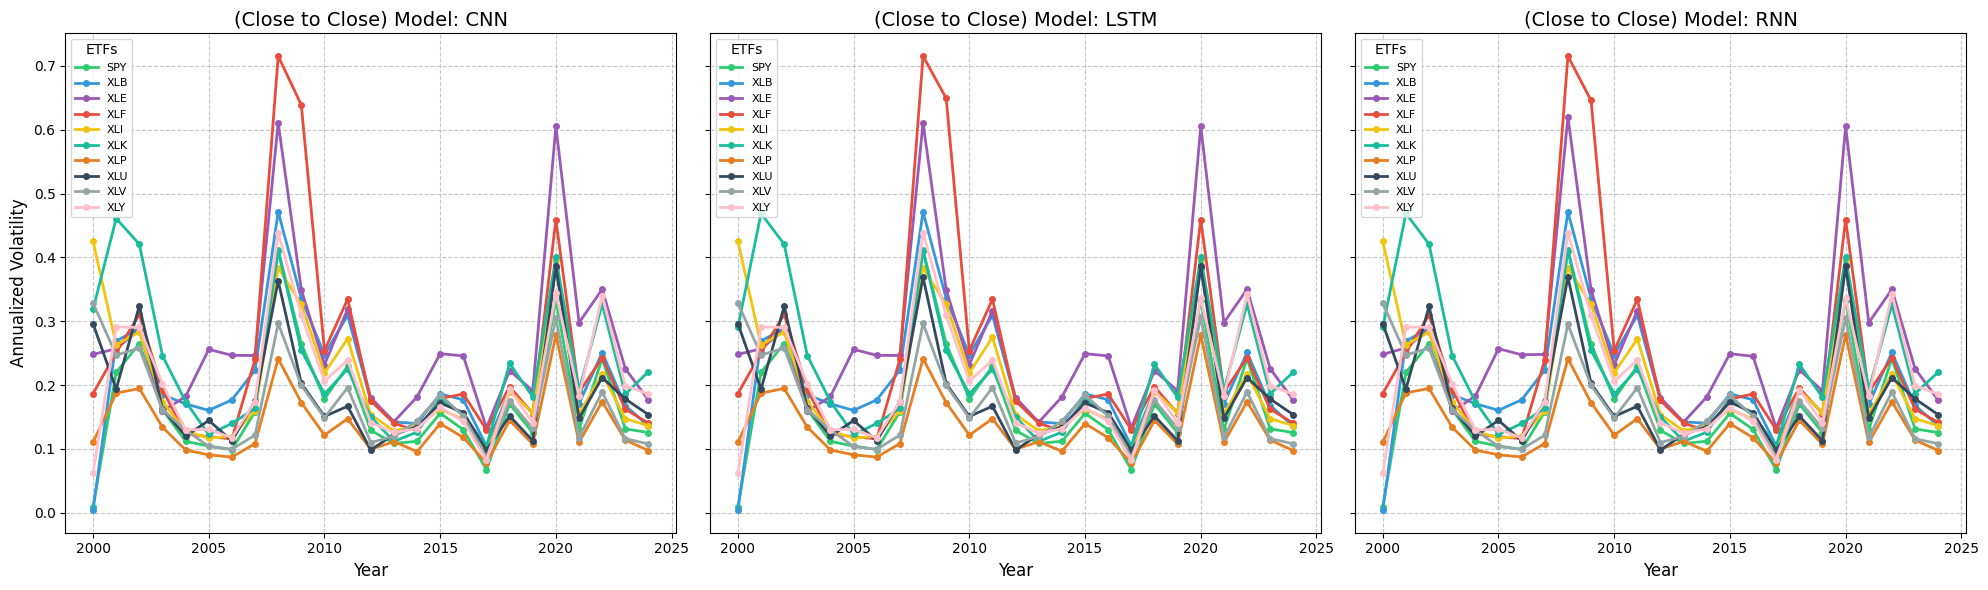

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('ctc_annualized_volatility.csv')

# Define a clean color palette for ETFs
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f', '#1abc9c', '#e67e22', '#34495e', '#95a5a6', 'pink']

# Create subplots for each model
models = df['Model'].unique()
fig, axes = plt.subplots(1, len(models), figsize=(20, 6), sharey=True)

for idx, model in enumerate(models):
    ax = axes[idx]
    model_data = df[df['Model'] == model]
    
    # Plot each ETF's data on the current subplot
    for etf_idx, etf in enumerate(model_data['ETF'].unique()):
        etf_data = model_data[model_data['ETF'] == etf]
        ax.plot(etf_data['Year'], etf_data['Annualized_Volatility'], 
                color=colors[etf_idx % len(colors)], 
                linewidth=2, 
                marker='o', 
                markersize=4, 
                label=etf)
    
    # Customize the subplot
    ax.set_title(f'(Close to Close) Model: {model.upper()}', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    if idx == 0:
        ax.set_ylabel('Annualized Volatility', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title="ETFs", fontsize=8, loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('ctc_volatility_model.png')
plt.show()


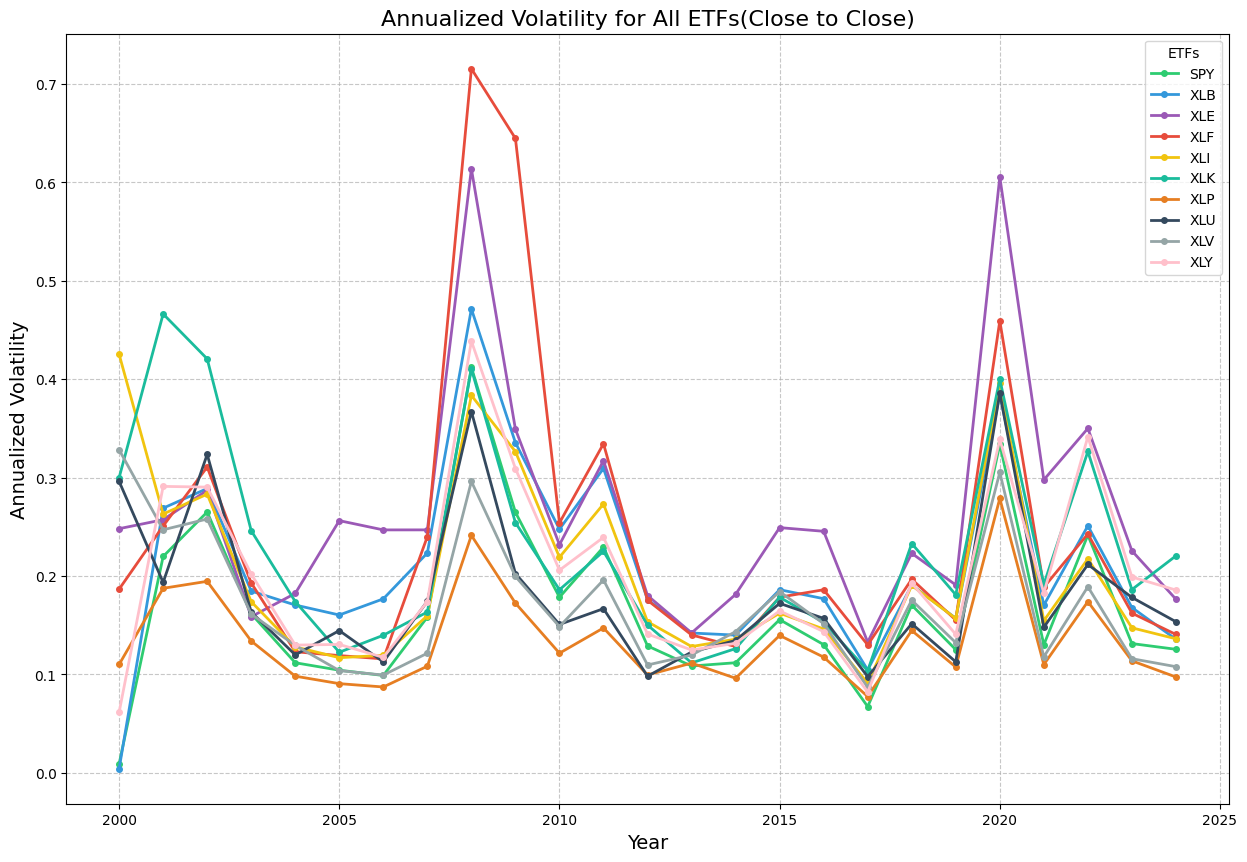

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('ctc_annualized_volatility.csv')

# Group the data by ETF and Year, and calculate the mean annualized volatility for each year
annual_volatility = df.groupby(['ETF', 'Year'])['Annualized_Volatility'].mean().reset_index()

# Define a clean color palette
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f', '#1abc9c', '#e67e22', '#34495e', '#95a5a6', 'pink']

# Create a single plot for all ETFs
plt.figure(figsize=(15, 10))
for idx, etf in enumerate(annual_volatility['ETF'].unique()):
    etf_data = annual_volatility[annual_volatility['ETF'] == etf]
    plt.plot(etf_data['Year'], etf_data['Annualized_Volatility'], 
             color=colors[idx % len(colors)], 
             linewidth=2, 
             marker='o', 
             markersize=4, 
             label=etf)

# Add titles and labels
plt.title('Annualized Volatility for All ETFs(Close to Close)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Annualized Volatility', fontsize=14)
plt.legend(title="ETFs", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('ctc_volatility.png')
# Display the plot
plt.show()


# MDD,Sharpe Ratio,Annual Returns

In [15]:
import pandas as pd
import numpy as np
import empyrical as ep

# Load the data
predicted_returns = pd.read_csv('etf_predicted_returns.csv')
annualized_volatility = pd.read_csv('ctc_annualized_volatility.csv')

# Convert date column to datetime
predicted_returns['date'] = pd.to_datetime(predicted_returns['date'])

def calculate_metrics(returns, volatility):
    annual_return = (1 + returns.mean()) ** 250 - 1
    sharpe_ratio = annual_return / volatility if volatility != 0 else 0
    mdd = ep.max_drawdown(returns)
    return sharpe_ratio, mdd, annual_return

results = []

for (etf, model), group in predicted_returns.groupby(['etf', 'model']):
    group = group.set_index('date').sort_index()
    
    for year in range(max(group.index.year.min(), 2001), group.index.year.max() + 1):
        year_returns = group[group.index.year == year]['predicted_daily_returns']
        
        if not year_returns.empty:
            vol_data = annualized_volatility[(annualized_volatility['ETF'] == etf) & 
                                             (annualized_volatility['Model'] == model) & 
                                             (annualized_volatility['Year'] == year)]
            
            if not vol_data.empty:
                vol = vol_data['Annualized_Volatility'].values[0]
            else:
                vol = year_returns.std() * np.sqrt(252)
            
            sharpe_ratio, mdd, annual_return = calculate_metrics(year_returns, vol)
            
            results.append({
                'ETF': etf,
                'Model': model,
                'Year': year,
                'Sharpe Ratio': sharpe_ratio,
                'MDD': mdd,
                'Annual Return': annual_return
            })

results_df = pd.DataFrame(results)

# Calculate statistics for each metric
metrics = ['Annual Return', 'Sharpe Ratio', 'MDD']
output_dfs = []

for metric in metrics:
    stats = results_df.groupby(['ETF', 'Model'])[metric].agg(['mean', 'median', 'std']).reset_index()
    stats.columns = ['ETF', 'Model', 'Average', 'Median', 'Standard Deviation']
    output_dfs.append(stats)

# Save each DataFrame to a separate CSV file
output_dfs[0].to_csv('annual_returns_stats.csv', index=False)
output_dfs[1].to_csv('sharpe_ratio_stats.csv', index=False)
output_dfs[2].to_csv('mdd_stats.csv', index=False)

print("Statistics have been saved to separate CSV files.")


C:\Users\tripa\AppData\Local\Temp\ipykernel_43424\4211112972.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  predicted_returns['date'] = pd.to_datetime(predicted_returns['date'])


Statistics have been saved to separate CSV files.
